<a href="https://colab.research.google.com/github/RichardDominik/neural-networks-CV/blob/master/NN_CV_hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Domáca úloha č. 1 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
from matplotlib import pyplot as plt

Načítanie datasetu Cifar 10

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
transform = transforms.ToTensor()
generator = torch.Generator().manual_seed(42)

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainset, valset = torch.utils.data.random_split(dataset, [45000, 5000], generator=generator)

Files already downloaded and verified
Files already downloaded and verified


Zobrazenie obrázkov z datasetu

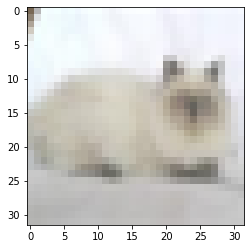

cat


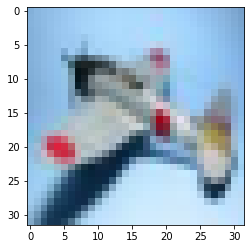

plane


In [ ]:
previewloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

for i, sample in enumerate(previewloader):
  if i > 1:
    break
  x, y = sample
  img = np.moveaxis(x.numpy()[0], 0, -1)
  plt.imshow(img)
  plt.show()
  print(classes[y.item()])

# Základný model

Training loss at step 0: 2.2993857860565186
Training loss at step 100: 1.9624378681182861
Training loss at step 200: 2.089033365249634
Training loss at step 300: 2.0501952171325684
Training loss at step 400: 1.7849929332733154
Training loss at step 500: 1.5414044857025146
Training loss at step 600: 1.7329238653182983
Training loss at step 700: 1.4485498666763306
Training loss at step 800: 1.4178111553192139
Training loss at step 900: 1.4663822650909424
Training loss at step 1000: 1.4433159828186035
Training loss at step 1100: 1.6722463369369507
Training loss at step 1200: 1.4790551662445068
Training loss at step 1300: 1.4964038133621216
Training loss at step 1400: 1.4591305255889893
Val loss at epoch 0: 1.3990589942142462
Val acc at epoch 0: 0.4926
Training loss at step 0: 1.2751961946487427
Training loss at step 100: 1.4159200191497803
Training loss at step 200: 1.3973661661148071
Training loss at step 300: 1.2777090072631836
Training loss at step 400: 1.180396556854248
Training loss 

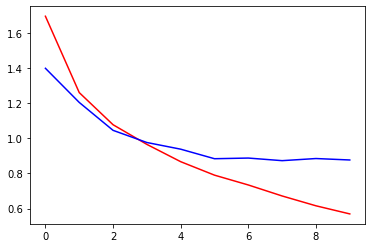

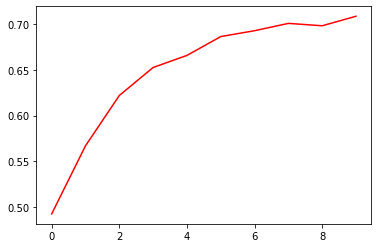

In [ ]:
from torch.nn import Sequential, Linear, ReLU, Softmax, Conv2d, MaxPool2d, Flatten, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

# skusit velkost kernelu 5 
KERNEL_SIZE_CONV = 3
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
#viac ako X epoch overfitting
NUMBER_OF_EPOCHS = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model, model_inference = build_model()
model, model_inference = model.to(device), model_inference.to(device)

dataloader_train = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)

ce_loss = CrossEntropyLoss().to(device)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

epoch_train_losses = []
epoch_val_losses = []
epoch_val_accs = []

def build_model():
  model = Sequential(Conv2d(3, 32, KERNEL_SIZE_CONV), MaxPool2d(2), ReLU(), 
                    Conv2d(32, 64, KERNEL_SIZE_CONV), MaxPool2d(2), ReLU(),
                    Conv2d(64, 128, KERNEL_SIZE_CONV), MaxPool2d(2), ReLU(),
                    Flatten(), 
                    Linear(512, 256), ReLU(), Linear(256, 128), ReLU(),
                    Linear(128, 10))

  # dim=1
  model_inference = Sequential(model, Softmax())
  return model, model_inference

# model, model_inference = build_model()
# model_inference(torch.from_numpy(np.zeros([1, 3, 32, 32], dtype=np.float32)))

def one_epoch(model, loss, optimizer, dataloader_train, dataloader_val, device, verbose=True):
  train_losses = []
  val_losses = []

  model.train()

  for i, batch in enumerate(dataloader_train):  
    x, y = batch[0].to(device), batch[1].to(device) 
    optimizer.zero_grad()

    out = model(x)
    loss = ce_loss(out, y)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    if i % 100 == 0 and verbose:
      print("Training loss at step {}: {}".format(i, loss.item()))

  model.eval()

  with torch.no_grad():
    correct = 0
    total = 0
    for i, batch in enumerate(dataloader_val):  
      x, y = batch[0].to(device), batch[1].to(device)  

      out = model(x)
      loss = ce_loss(out, y)
      acc = torch.sum(torch.argmax(out, dim=-1) == y)
      correct += acc.item()
      total += len(batch[1])
      val_losses.append(loss.item())

  val_acc = correct / total

  return np.mean(train_losses), np.mean(val_losses), val_acc

for e in range(NUMBER_OF_EPOCHS):
  train_loss, val_loss, val_acc = one_epoch(model, ce_loss, optimizer, dataloader_train, dataloader_val, device)

  print("Val loss at epoch {}: {}".format(e, val_loss))
  print("Val acc at epoch {}: {}".format(e, val_acc))

  epoch_train_losses.append(train_loss)
  epoch_val_losses.append(val_loss)
  epoch_val_accs.append(val_acc)

# pridat nazvy + legendy
plt.plot(epoch_train_losses, c='r')
plt.plot(epoch_val_losses, c='b')
plt.show()

plt.plot(epoch_val_accs, c='r')
plt.show()

In [ ]:
# Komentar k predchadajuzemu modelu 

# vstupom je obrazok 32x32 

# Conv2d(3, 32, KERNEL_SIZE_CONV)
# pocet vstup kanalov RGB, pocet vyst kanalov volime si samostatne, kernel size
# torch.Size([32, 32, 30, 30])
# batch_size, pocet vyst kanalov, vyska obrazka, sirka obrazka 

# MaxPool2d(2)
# velkost poolingu 2x2 a stride je 1 
# torch.Size([32, 32, 15, 15])

# ReLU()
# torch.Size([32, 32, 15, 15])

# Conv2d(32, 64, KERNEL_SIZE_CONV)
# pocet vstup kanalov z predchadz vsrvy je 32, pocet vyst kanalov volime si samostatne, kernel size
# torch.Size([32, 64, 13, 13])

# MaxPool2d(2)
# torch.Size([32, 64, 6, 6])

# ReLU()
# torch.Size([32, 64, 6, 6])

# Conv2d(64, 128, KERNEL_SIZE_CONV)
# pocet vstup kanalov z predchadz vsrvy je 64, pocet vyst kanalov volime si samostatne, kernel size
# torch.Size([32, 128, 4, 4])

# MaxPool2d(2)
# torch.Size([32, 128, 2, 2])

# ReLU()
# torch.Size([32, 128, 2, 2])

# Flatten()
# toto bude 128 * 2 * 2] 
# torch.Size([32, 512])

# in_features, out_features
# Linear(512, 256)
# torch.Size([32, 256])

# ReLU()
# torch.Size([32, 256])
# torch.Size([32, 256])

# Linear(256, 128), ReLU(), Linear(128, 10)
# torch.Size([32, 10])

Upraveny zakladny model

Training loss at step 0: 2.2949934005737305
Training loss at step 100: 1.8654372692108154
Training loss at step 200: 2.015465497970581
Training loss at step 300: 1.6535277366638184
Training loss at step 400: 1.730231761932373
Training loss at step 500: 1.5983542203903198
Training loss at step 600: 1.4373259544372559
Training loss at step 700: 1.5275741815567017
Training loss at step 800: 1.4165524244308472
Training loss at step 900: 1.42999267578125
Training loss at step 1000: 1.4394112825393677
Training loss at step 1100: 1.3509445190429688
Training loss at step 1200: 1.301119327545166
Training loss at step 1300: 1.233428716659546
Training loss at step 1400: 1.7274680137634277
Val loss at epoch 0: 1.3763381759072566
Val acc at epoch 0: 0.5
Training loss at step 0: 1.8363393545150757
Training loss at step 100: 1.2067195177078247
Training loss at step 200: 1.3108240365982056
Training loss at step 300: 1.7193408012390137
Training loss at step 400: 0.8632066249847412
Training loss at step

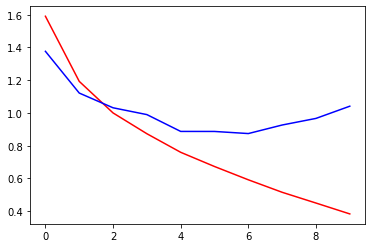

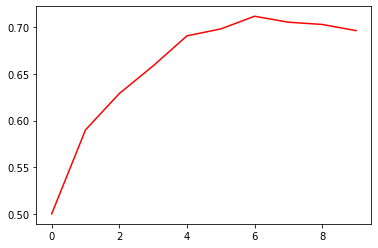

In [ ]:
from torch.nn import Sequential, Linear, ReLU, Softmax, Conv2d, MaxPool2d, AdaptiveAvgPool2d, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

KERNEL_SIZE_CONV = 3
STRIDE = 2
PADDING = 1
MAX_POOL_KERNEL = 2
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
# viac ako 10 epoch overfitting
NUMBER_OF_EPOCHS = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def build_model():
  model = Sequential(Conv2d(3, 16, KERNEL_SIZE_CONV, 1, PADDING), MaxPool2d(MAX_POOL_KERNEL, STRIDE), ReLU(),
                    Conv2d(16, 32, KERNEL_SIZE_CONV, 1, PADDING), MaxPool2d(MAX_POOL_KERNEL, STRIDE), ReLU(),
                    Conv2d(32, 64, KERNEL_SIZE_CONV, 1, PADDING), MaxPool2d(MAX_POOL_KERNEL, STRIDE), ReLU(),
                    Flatten(),
                    Linear(1024, 512), ReLU(),
                    Linear(512, 256), ReLU(),
                    Linear(256, 128), ReLU(),
                    Linear(128, 10))
  
  model_inference = Sequential(model, Softmax())
  return model, model_inference


model, model_inference = build_model()
model, model_inference = model.to(device), model_inference.to(device)

dataloader_train = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)

ce_loss = CrossEntropyLoss().to(device)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

epoch_train_losses = []
epoch_val_losses = []
epoch_val_accs = []

def one_epoch(model, loss, optimizer, dataloader_train, dataloader_val, device, verbose=True):
  train_losses = []
  val_losses = []

  model.train()

  for i, batch in enumerate(dataloader_train):  
    # i hovori o tom ktora davka
   
    # x je obrazok 
    # y je trieda do ktorej obr patri
    x, y = batch[0].to(device), batch[1].to(device) 
    optimizer.zero_grad()

    out = model(x)
    # print(out.shape)

    loss = ce_loss(out, y)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    if i % 100 == 0 and verbose:
      print("Training loss at step {}: {}".format(i, loss.item()))

  model.eval()

  with torch.no_grad():
    correct = 0
    total = 0
    for i, batch in enumerate(dataloader_val):  
      x, y = batch[0].to(device), batch[1].to(device)  

      out = model(x)
      loss = ce_loss(out, y)
      acc = torch.sum(torch.argmax(out, dim=-1) == y)
      correct += acc.item()
      total += len(batch[1])
      val_losses.append(loss.item())

  val_acc = correct / total

  return np.mean(train_losses), np.mean(val_losses), val_acc

for e in range(NUMBER_OF_EPOCHS):
  train_loss, val_loss, val_acc = one_epoch(model, ce_loss, optimizer, dataloader_train, dataloader_val, device)

  print("Val loss at epoch {}: {}".format(e, val_loss))
  print("Val acc at epoch {}: {}".format(e, val_acc))

  epoch_train_losses.append(train_loss)
  epoch_val_losses.append(val_loss)
  epoch_val_accs.append(val_acc)

# pridat nazvy + legendy
plt.plot(epoch_train_losses, c='r')
plt.plot(epoch_val_losses, c='b')
plt.show()

plt.plot(epoch_val_accs, c='r')
plt.show()

# Aktivácie

Funkcie pre budovanie modelov. Oskúšané aktivačné funkcie: Sigmoid, tanh, ELU, LeakyReLU a PReLU

In [ ]:
from torch.nn import Sigmoid, Tanh, ELU, LeakyReLU, PReLU

# Sigmoid
def build_model_using_sigmoid_activation_function():
  model = Sequential(Conv2d(3, 16, KERNEL_SIZE_CONV, 1, PADDING), MaxPool2d(MAX_POOL_KERNEL, STRIDE), Sigmoid(),
                  Conv2d(16, 32, KERNEL_SIZE_CONV, 1, PADDING), MaxPool2d(MAX_POOL_KERNEL, STRIDE), Sigmoid(),
                  Conv2d(32, 64, KERNEL_SIZE_CONV, 1, PADDING), MaxPool2d(MAX_POOL_KERNEL, STRIDE), Sigmoid(),
                  Flatten(),
                  Linear(1024, 512), Sigmoid(),
                  Linear(512, 256), Sigmoid(),
                  Linear(256, 128), Sigmoid(),
                  Linear(128, 10))

  model_inference = Sequential(model, Softmax())
  return model, model_inference

# Tanh
def build_model_using_tanh_activation_function():
  model = Sequential(Conv2d(3, 16, KERNEL_SIZE_CONV, 1, PADDING), MaxPool2d(MAX_POOL_KERNEL, STRIDE), Tanh(),
                    Conv2d(16, 32, KERNEL_SIZE_CONV, 1, PADDING), MaxPool2d(MAX_POOL_KERNEL, STRIDE), Tanh(),
                    Conv2d(32, 64, KERNEL_SIZE_CONV, 1, PADDING), MaxPool2d(MAX_POOL_KERNEL, STRIDE), Tanh(),
                    Flatten(),
                    Linear(1024, 512), Tanh(),
                    Linear(512, 256), Tanh(),
                    Linear(256, 128), Tanh(),
                    Linear(128, 10))

  model_inference = Sequential(model, Softmax())
  return model, model_inference

# ELU
def build_model_using_elu_activation_function():
  model = Sequential(Conv2d(3, 16, KERNEL_SIZE_CONV, 1, PADDING), MaxPool2d(MAX_POOL_KERNEL, STRIDE), ELU(),
                    Conv2d(16, 32, KERNEL_SIZE_CONV, 1, PADDING), MaxPool2d(MAX_POOL_KERNEL, STRIDE), ELU(),
                    Conv2d(32, 64, KERNEL_SIZE_CONV, 1, PADDING), MaxPool2d(MAX_POOL_KERNEL, STRIDE), ELU(),
                    Flatten(),
                    Linear(1024, 512), ELU(),
                    Linear(512, 256), ELU(),
                    Linear(256, 128), ELU(),
                    Linear(128, 10))

  model_inference = Sequential(model, Softmax())
  return model, model_inference

# LeakyReLu
ALPHA = 0.1

def build_model_using_leaky_relu_activation_function():
  model = Sequential(Conv2d(3, 16, KERNEL_SIZE_CONV, 1, PADDING), MaxPool2d(MAX_POOL_KERNEL, STRIDE), LeakyReLU(ALPHA),
                    Conv2d(16, 32, KERNEL_SIZE_CONV, 1, PADDING), MaxPool2d(MAX_POOL_KERNEL, STRIDE), LeakyReLU(ALPHA),
                    Conv2d(32, 64, KERNEL_SIZE_CONV, 1, PADDING), MaxPool2d(MAX_POOL_KERNEL, STRIDE), LeakyReLU(ALPHA),
                    Flatten(),
                    Linear(1024, 512), LeakyReLU(ALPHA),
                    Linear(512, 256), LeakyReLU(ALPHA),
                    Linear(256, 128), LeakyReLU(ALPHA),
                    Linear(128, 10))

  model_inference = Sequential(model, Softmax())
  return model, model_inference

# PReLU
def build_model_using_prelu_activation_function():
  model = Sequential(Conv2d(3, 16, KERNEL_SIZE_CONV, 1, PADDING), MaxPool2d(MAX_POOL_KERNEL, STRIDE), PReLU(),
                    Conv2d(16, 32, KERNEL_SIZE_CONV, 1, PADDING), MaxPool2d(MAX_POOL_KERNEL, STRIDE), PReLU(),
                    Conv2d(32, 64, KERNEL_SIZE_CONV, 1, PADDING), MaxPool2d(MAX_POOL_KERNEL, STRIDE), PReLU(),
                    Flatten(),
                    Linear(1024, 512), PReLU(),
                    Linear(512, 256), PReLU(),
                    Linear(256, 128), PReLU(),
                    Linear(128, 10))

  model_inference = Sequential(model, Softmax())
  return model, model_inference

Inicialializácia modelov podľa aktivačných funkcií

In [ ]:
# Sigmoid model
sigmoid_model, sigmoid_model_inference = build_model_using_sigmoid_activation_function()
sigmoid_model, sigmoid_model_inference = sigmoid_model.to(device), sigmoid_model_inference.to(device)

# Tanh model
tanh_model, tanh_model_inference = build_model_using_tanh_activation_function()
tanh_model, tanh_model_inference = tanh_model.to(device), tanh_model_inference.to(device)

# ELU model
elu_model, elu_model_inference = build_model_using_elu_activation_function()
elu_model, elu_model_inference = elu_model.to(device), elu_model_inference.to(device)

# LeakyReLu model
leaky_relu_model, leaky_relu_model_inference = build_model_using_leaky_relu_activation_function()
leaky_relu_model, leaky_relu_model_inference = leaky_relu_model.to(device), leaky_relu_model_inference.to(device)

# PReLU model
prelu_model, prelu_model_inference = build_model_using_prelu_activation_function()
prelu_model, prelu_model_inference = prelu_model.to(device), prelu_model_inference.to(device)

# All models
models = [('sigmoid', sigmoid_model), ('tanh', tanh_model), ('elu', elu_model), ('leaky relu', leaky_relu_model), ('prelu', prelu_model)]

Trénovanie modelov

sigmoid
Val loss at epoch 0: 2.0175520743534063
Val acc at epoch 0: 0.2532
Val loss at epoch 1: 1.9086950751626568
Val acc at epoch 1: 0.3006
Val loss at epoch 2: 1.8278964985707762
Val acc at epoch 2: 0.3308
Val loss at epoch 3: 1.6646716594696045
Val acc at epoch 3: 0.4002
Val loss at epoch 4: 1.5574748311073157
Val acc at epoch 4: 0.442
Val loss at epoch 5: 1.4703697072472541
Val acc at epoch 5: 0.4666
Val loss at epoch 6: 1.4181863544093576
Val acc at epoch 6: 0.4874
Val loss at epoch 7: 1.3689845758638564
Val acc at epoch 7: 0.5054
Val loss at epoch 8: 1.3212291484425782
Val acc at epoch 8: 0.528
Val loss at epoch 9: 1.3262120041118306
Val acc at epoch 9: 0.5162



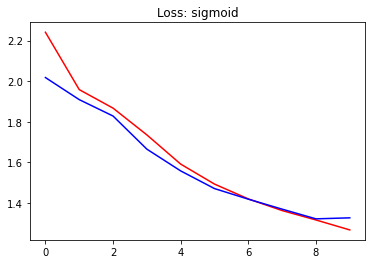

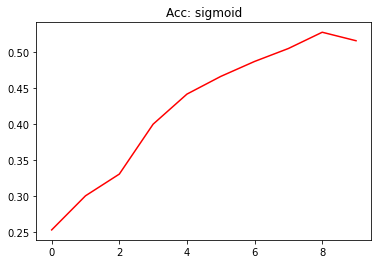

tanh
Val loss at epoch 0: 1.232950543901723
Val acc at epoch 0: 0.562
Val loss at epoch 1: 1.0873909790045138
Val acc at epoch 1: 0.6268
Val loss at epoch 2: 0.9902313708499738
Val acc at epoch 2: 0.651
Val loss at epoch 3: 0.9547437626844758
Val acc at epoch 3: 0.6686
Val loss at epoch 4: 0.9094393116653345
Val acc at epoch 4: 0.693
Val loss at epoch 5: 0.8756923480018689
Val acc at epoch 5: 0.7032
Val loss at epoch 6: 0.9395679372131445
Val acc at epoch 6: 0.6904
Val loss at epoch 7: 0.8897289810286966
Val acc at epoch 7: 0.707
Val loss at epoch 8: 0.9310092643188064
Val acc at epoch 8: 0.7156
Val loss at epoch 9: 1.0017708507692737
Val acc at epoch 9: 0.6998



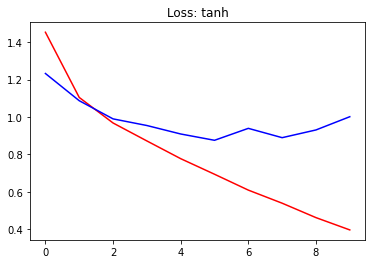

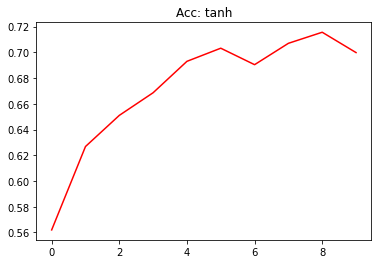

elu
Val loss at epoch 0: 1.2090489621375018
Val acc at epoch 0: 0.5664
Val loss at epoch 1: 1.138016583813224
Val acc at epoch 1: 0.5902
Val loss at epoch 2: 0.9526134156117774
Val acc at epoch 2: 0.672
Val loss at epoch 3: 0.9536869514520001
Val acc at epoch 3: 0.6748
Val loss at epoch 4: 0.8929671147826371
Val acc at epoch 4: 0.7004
Val loss at epoch 5: 0.8416469579289674
Val acc at epoch 5: 0.711
Val loss at epoch 6: 0.8758442189283432
Val acc at epoch 6: 0.7168
Val loss at epoch 7: 0.8833749294281006
Val acc at epoch 7: 0.731
Val loss at epoch 8: 0.9575112923315376
Val acc at epoch 8: 0.7286
Val loss at epoch 9: 1.0636247796997143
Val acc at epoch 9: 0.7298



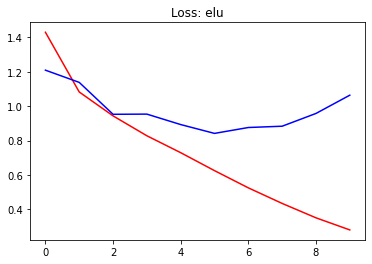

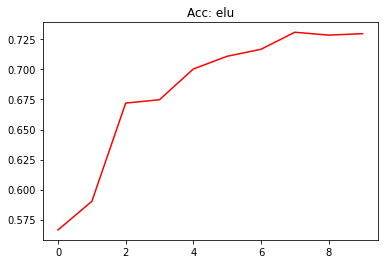

leaky relu
Val loss at epoch 0: 1.2768197359552809
Val acc at epoch 0: 0.5328
Val loss at epoch 1: 0.999308770629251
Val acc at epoch 1: 0.6444
Val loss at epoch 2: 0.9558733770042468
Val acc at epoch 2: 0.674
Val loss at epoch 3: 0.9037446571383506
Val acc at epoch 3: 0.6942
Val loss at epoch 4: 0.861642561141093
Val acc at epoch 4: 0.7136
Val loss at epoch 5: 0.8095064260967219
Val acc at epoch 5: 0.7334
Val loss at epoch 6: 0.8316127160552201
Val acc at epoch 6: 0.7306
Val loss at epoch 7: 0.9256741814552598
Val acc at epoch 7: 0.7336
Val loss at epoch 8: 1.0418522815415814
Val acc at epoch 8: 0.7238
Val loss at epoch 9: 1.0957606193745972
Val acc at epoch 9: 0.7256



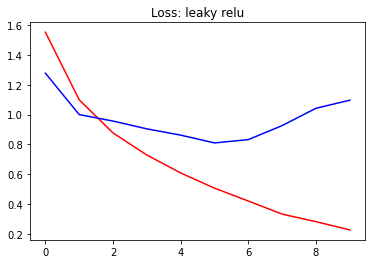

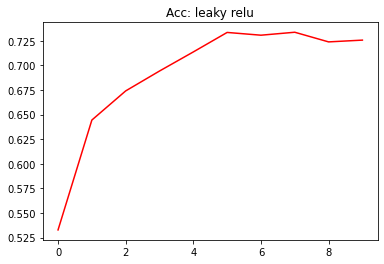

prelu
Val loss at epoch 0: 1.1410436690992611
Val acc at epoch 0: 0.5898
Val loss at epoch 1: 0.9450120067900154
Val acc at epoch 1: 0.6628
Val loss at epoch 2: 0.9020113933617901
Val acc at epoch 2: 0.6972
Val loss at epoch 3: 0.8558331409077735
Val acc at epoch 3: 0.714
Val loss at epoch 4: 0.8078262843903462
Val acc at epoch 4: 0.73
Val loss at epoch 5: 0.9363981137989433
Val acc at epoch 5: 0.7212
Val loss at epoch 6: 1.0788808074916245
Val acc at epoch 6: 0.725
Val loss at epoch 7: 1.1001111601188684
Val acc at epoch 7: 0.7106
Val loss at epoch 8: 1.2373809935940299
Val acc at epoch 8: 0.7136
Val loss at epoch 9: 1.542557108743935
Val acc at epoch 9: 0.7136



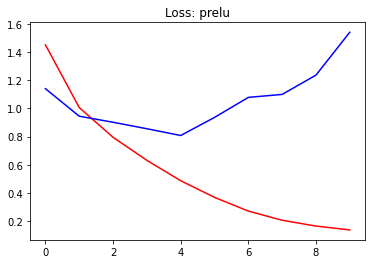

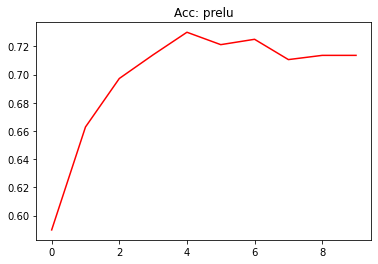

In [ ]:
for activation_function_name, model in models:
  optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
  epoch_train_losses = []
  epoch_val_losses = []
  epoch_val_accs = []

  print(activation_function_name) 

  for e in range(NUMBER_OF_EPOCHS):
    train_loss, val_loss, val_acc = one_epoch(model, ce_loss, optimizer, dataloader_train, dataloader_val, device, False)

    print("Val loss at epoch {}: {}".format(e, val_loss))
    print("Val acc at epoch {}: {}".format(e, val_acc))

    epoch_train_losses.append(train_loss)
    epoch_val_losses.append(val_loss)
    epoch_val_accs.append(val_acc)

  print('')

  # pridat nazvy + legendy
  plt.title('Loss: ' + activation_function_name)
  plt.plot(epoch_train_losses, c='r')
  plt.plot(epoch_val_losses, c='b')
  plt.show()

  plt.title('Acc: ' + activation_function_name)
  plt.plot(epoch_val_accs, c='r')
  plt.show()

# Optimalizácia

In [ ]:
from torch.optim import SGD

NUMBER_OF_OPT_EPOCHS = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
baseline_model, baseline_model_inference = build_model()
baseline_model, baseline_model_inference = baseline_model.to(device), baseline_model_inference.to(device)

dataloader_train = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)

optimizers = [
    ('SGD: lr: 0.01, momentum: 0.9', SGD(baseline_model.parameters(), lr=0.01, momentum=0.9)),
    ('SGD: lr: 0.01, momentum: 0', SGD(baseline_model.parameters(), lr=0.01)),
    ('SGD: lr: 0.001, momentum: 0', SGD(baseline_model.parameters(), lr=1e-3)),
    ('SGD: lr: 0.05, momentum: 0', SGD(baseline_model.parameters(), lr=0.05)),
]

# TODO: implement me
batch_sizes = []

for optDetails, optimizerTest in optimizers:
  

  ce_loss = CrossEntropyLoss().to(device)
  epoch_train_losses = []
  epoch_val_losses = []
  epoch_val_accs = []

  print(optDetails) 
  print(optimizerTest)

  for e in range(NUMBER_OF_OPT_EPOCHS):
    train_loss, val_loss, val_acc = one_epoch(baseline_model, ce_loss, optimizerTest, dataloader_train, dataloader_val, device, False)

    print("Val loss at epoch {}: {}".format(e, val_loss))
    print("Val acc at epoch {}: {}".format(e, val_acc))

    epoch_train_losses.append(train_loss)
    epoch_val_losses.append(val_loss)
    epoch_val_accs.append(val_acc)

  print('')

  # pridat nazvy + legendy
  plt.title('Loss: ' + optDetails)
  plt.plot(epoch_train_losses, c='r')
  plt.plot(epoch_val_losses, c='b')
  plt.show()

  plt.title('Acc: ' + optDetails)
  plt.plot(epoch_val_accs, c='r')
  plt.show()


Batch sizes

In [ ]:
batch_sizes = [10, 25, 40]

for bs in batch_sizes:
  baseline_model, baseline_model_inference = build_model()
  baseline_model, baseline_model_inference = baseline_model.to(device), baseline_model_inference.to(device)
  dataloader_train = DataLoader(trainset, batch_size=bs, shuffle=True)
  dataloader_val = DataLoader(valset, batch_size=bs, shuffle=True)
  optimizer = Adam(baseline_model.parameters(), lr=LEARNING_RATE)

  ce_loss = CrossEntropyLoss().to(device)
  epoch_train_losses = []
  epoch_val_losses = []
  epoch_val_accs = []
  print('Batch size: ' + str(bs))

  for e in range(NUMBER_OF_OPT_EPOCHS):
    train_loss, val_loss, val_acc = one_epoch(baseline_model, ce_loss, optimizer, dataloader_train, dataloader_val, device, False)

    print("Val loss at epoch {}: {}".format(e, val_loss))
    print("Val acc at epoch {}: {}".format(e, val_acc))

    epoch_train_losses.append(train_loss)
    epoch_val_losses.append(val_loss)
    epoch_val_accs.append(val_acc)

  print('')

  # pridat nazvy + legendy
  plt.title('Loss: ' + str(bs))
  plt.plot(epoch_train_losses, c='r')
  plt.plot(epoch_val_losses, c='b')
  plt.show()

  plt.title('Acc: ' + str(bs))
  plt.plot(epoch_val_accs, c='r')
  plt.show()

# Dropout a Augmentácia 

# Hlboká sieť (5b)

# Najlepší model 